# Lab: Building a Model Evaluator with LangGraph

This notebook refactors our previous model comparison script into a stateful, robust agent using LangGraph. By structuring the workflow as a graph, we gain better control, observability, and the ability to easily extend the process in the future.

### Key Features:
1.  **Stateful Agent**: The entire workflow is managed within a `StateGraph`.
2.  **Modular Nodes**: Each logical step (generating a question, querying models, judging) is a separate, well-defined node.
3.  **Configuration Driven**: Uses a `config.ini` file for settings.
4.  **Visualization**: Displays a diagram of the agent's graph structure.

## 1. Setup and Installation

In [1]:
!pip install python-dotenv openai langgraph ipykernel langchain

## 2. Imports and Configuration Loading

**Purpose**: To import necessary libraries and load all settings from our external `config.ini` file.

In [2]:
import os
import json
import warnings
import configparser
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import Markdown, display, Image
from typing import TypedDict, List
from langgraph.graph import StateGraph, END, START
# NEW IMPORT for text splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

warnings.filterwarnings('ignore')

try:
    load_dotenv("C:/Users/adminuser/dev.env")
    config = configparser.ConfigParser()
    config.read('1-config.ini')

    # Model settings
    JUDGE_MODEL = config.get('Models', 'judge_model')
    competitor_models_str = config.get('Models', 'competitor_models')
    competitor_models = [model.strip() for model in competitor_models_str.split(',')]
    
    # NEW: Chunk size for large answers
    CHUNK_SIZE = config.getint('Parameters', 'chunk_size', fallback=2000)
    CHUNK_OVERLAP = config.getint('Parameters', 'chunk_overlap', fallback=200)

    print("Configuration loaded successfully!")
    print(f"Competitor models: {competitor_models}")
    print(f"Chunk Size: {CHUNK_SIZE}, Chunk Overlap: {CHUNK_OVERLAP}")

except Exception as e:
    print(f"Error loading configuration: {e}")


Configuration loaded successfully!
Competitor models: ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']
Chunk Size: 2000, Chunk Overlap: 200


## 3. Define the Agent's State

**Purpose**: To define the data structure that will act as the agent's memory. This `GraphState` will be passed to every node in our graph.

In [3]:
from typing import TypedDict, List, Any

class GraphState(TypedDict):
    """Represents the state of our model evaluation workflow."""
    question: str
    competitor_models: List[str]
    answers: List[dict]
    judgement: str
    error_message: str
    answers_to_rank: List[dict]
    current_model_index: int
    current_chunk_index: int
    running_judgment: str

## 4. Define the Agent's Nodes

**Purpose**: To create the functions that will perform the actual work. Each function takes the current state as input and returns a dictionary with the values to update in the state.

In [4]:
def generate_question_node(state: GraphState):
    """Generates the challenge question."""
    print("--- NODE: Generating Question ---")
    request = "Please come up with a challenging, nuanced question that I can ask a number of LLMs to evaluate their intelligence. Answer only with the question, no explanation or preamble."
    messages = [{"role": "user", "content": request}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages)
        question = response.choices[0].message.content
        return {"question": question}
    except Exception as e:
        return {"error_message": f"Failed to generate question: {e}"}

def query_models_node(state: GraphState):
    """Queries each competitor model with the challenge question."""
    print("--- NODE: Querying Competitor Models ---")
    question = state['question']
    models_to_query = state['competitor_models']
    messages = [{"role": "user", "content": question}]
    current_answers = []
    client = OpenAI()

    for model_name in models_to_query:
        print(f"  - Querying {model_name}...")
        try:
            response = client.chat.completions.create(model=model_name, messages=messages)
            answer = response.choices[0].message.content
            current_answers.append({"model": model_name, "answer": answer})
        except Exception as e:
            error_message = f"Could not get response from {model_name}: {e}"
            print(f"    ERROR: {error_message}")
            current_answers.append({"model": model_name, "answer": error_message})

    return {"answers": current_answers}


In [5]:
def increment_model_index_node(state: GraphState):
    """Increments the model index and resets the chunk index."""
    print("--- NODE: Moving to Next Model ---")
    model_index = state['current_model_index']

    return {
        "current_model_index": model_index + 1,
        "current_chunk_index": 0, # Reset for the new model's chunks
    }

In [6]:
def prepare_for_judging_node(state: GraphState):
    """Chunks long answers and initializes the state for the judging loop."""
    print("--- NODE: Preparing for Judging ---")
    answers = state['answers']
    answers_to_rank = []

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
    )

    for answer in answers:
        long_answer = answer['answer']
        chunks = text_splitter.split_text(long_answer)
        answers_to_rank.append({"model": answer['model'], "chunks": chunks})
    
    return {
        "answers_to_rank": answers_to_rank,
        "current_model_index": 0,
        "current_chunk_index": 0,
        "running_judgment": "No initial judgment.",
    }

In [7]:
import json

def final_judge_node(state: GraphState):
    """Generates the final ranking based on the cumulative judgment memory."""
    print("--- NODE: Final Judge Ranking ---")
    question = state['question']
    running_judgment = state['running_judgment']
    model_names = [ans['model'] for ans in state['answers_to_rank']]

    final_ranking_prompt = (
        f"You have completed a detailed evaluation of multiple AI models' answers. "
        f"The question was: '{question}'. "
        f"Your final thoughts and comparative analysis are:\n<final_assessment_context>{running_judgment}</final_assessment_context>\n\n"
        f"Based on this cumulative assessment, provide the definitive ranking of the models from best to worst. "
        f"The models were: {', '.join(model_names)}. "
        f"Respond with a JSON object. The object should have a single key, \"results\", "
        f"which is a list of the model names in ranked order. Example: {{\"results\": [\"gpt-4o\", \"gpt-3.5-turbo\"]}}"
    )
    messages = [{"role": "user", "content": final_ranking_prompt}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages, response_format={"type": "json_object"})
        response_content = response.choices[0].message.content
        judgement_json = json.loads(response_content)
        return {"judgement": judgement_json['results']}
    except json.JSONDecodeError:
        # If parsing fails, return the raw text with an error
        return {
            "judgement": response_content,
            "error_message": "Failed to parse the JSON from the final judge."
        }
    except Exception as e:
        return {"error_message": f"Failed to get final judgement: {e}"}

In [8]:
def send_chunk_to_judge_node(state: GraphState):
    """Sends the next chunk of the current answer to the judge model for evaluation."""
    print("--- NODE: Sending Chunk to Judge ---")
    question = state['question']
    running_judgment = state['running_judgment']
    answers_to_rank = state['answers_to_rank']
    model_index = state['current_model_index']
    chunk_index = state['current_chunk_index']
    
    current_model = answers_to_rank[model_index]['model']
    current_chunk = answers_to_rank[model_index]['chunks'][chunk_index]
    total_chunks = len(answers_to_rank[model_index]['chunks'])

    judge_prompt = (
        f"You are an impartial judge. The question is: '{question}'. "
        f"You are evaluating the answer from model '{current_model}'. "
        f"Here is chunk {chunk_index + 1} of {total_chunks}. "
        f"You may have received previous chunks or other models' answers.\n\n"
        f"Current running judgment:\n<judgment>{running_judgment}</judgment>\n\n"
        f"New chunk to evaluate:\n<chunk>{current_chunk}</chunk>\n\n"
        f"Please provide your updated assessment based on all content you have seen so far. "
        f"Your response should be a single paragraph summary of the updated judgment. Do not provide a final ranking yet."
    )

    messages = [{"role": "user", "content": judge_prompt}]
    try:
        client = OpenAI()
        response = client.chat.completions.create(model=JUDGE_MODEL, messages=messages)
        updated_judgment = response.choices[0].message.content
        return {"running_judgment": updated_judgment, "current_chunk_index": chunk_index + 1}
    except Exception as e:
        print(f"Failed to get judgment for chunk: {e}")
        return {"error_message": f"Failed to get judgment for chunk: {e}"}

In [9]:
def decide_next_step_node(state: GraphState):
    """
    Determines the next step after a chunk has been judged.
    """
    # First, check if there are more chunks for the CURRENT model
    answers_to_rank = state['answers_to_rank']
    model_index = state['current_model_index']
    chunk_index = state['current_chunk_index']
    
    if chunk_index < len(answers_to_rank[model_index]['chunks']):
        print("--- DECISION: Continue to next chunk for current model ---")
        return "continue_chunks"

    # If no more chunks, check if there are more models
    else:
        if model_index + 1 < len(answers_to_rank):
            print("--- DECISION: All chunks processed, moving to next model ---")
            return "next_model"
        else:
            print("--- DECISION: All models have been judged ---")
            return "end_all_loops"

## 5. Construct and Visualize the Graph

**Purpose**: To wire the nodes together into a coherent workflow and visualize the resulting graph.

LangGraph workflow compiled successfully!


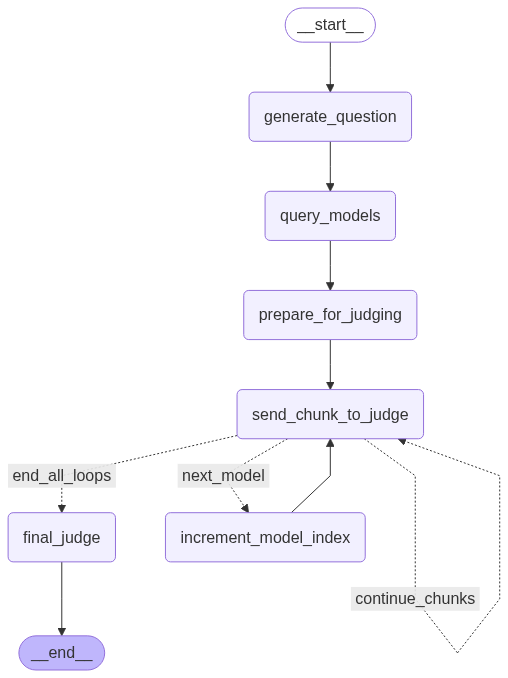

In [10]:
workflow = StateGraph(GraphState)

# Add ONLY the worker nodes
workflow.add_node("generate_question", generate_question_node)
workflow.add_node("query_models", query_models_node)
workflow.add_node("prepare_for_judging", prepare_for_judging_node)
workflow.add_node("send_chunk_to_judge", send_chunk_to_judge_node)
workflow.add_node("final_judge", final_judge_node)
workflow.add_node("increment_model_index", increment_model_index_node) 

# --- Define Edges ---

workflow.add_edge(START, "generate_question")
workflow.add_edge("generate_question", "query_models")
workflow.add_edge("query_models", "prepare_for_judging")
workflow.add_edge("prepare_for_judging", "send_chunk_to_judge")

# This new conditional edge replaces the previous two
workflow.add_conditional_edges(
    "send_chunk_to_judge",
    decide_next_step_node,
    {
        "continue_chunks": "send_chunk_to_judge",
        "next_model": "increment_model_index",
        "end_all_loops": "final_judge"
    }
)

workflow.add_edge("increment_model_index", "send_chunk_to_judge")
workflow.add_edge("final_judge", END)

# Compile the app
app = workflow.compile()

print("LangGraph workflow compiled successfully!")

# Display the graph visualization
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 6. Execute the Agent Workflow

**Purpose**: To run our newly created LangGraph agent. We prepare the initial state and then invoke the graph.

In [11]:
# Prepare the initial state for the graph.
initial_state = {
    "competitor_models": competitor_models
}

print("--- Invoking Agent Workflow ---")
final_state = None
try:
    # app.stream() executes the graph and streams the output of each node.
    # The 'final_state' variable will be updated after each step, so when
    # the loop finishes, it will hold the complete final state.
    for event in app.stream(initial_state):
        for node_name, updated_state in event.items():
            print(f"\n--- Output from Node: '{node_name}' ---")
            print(updated_state)
            final_state = updated_state # This captures the latest state

except Exception as e:
    print(f"An error occurred during the workflow execution: {e}")

print("\n--- Workflow Complete ---")

--- Invoking Agent Workflow ---
--- NODE: Generating Question ---

--- Output from Node: 'generate_question' ---
{'question': 'How might the concept of personal identity evolve in a society where advanced technology enables the complete transfer of human consciousness into digital form, and what ethical implications could arise from such a development?'}
--- NODE: Querying Competitor Models ---
  - Querying gpt-3.5-turbo...
  - Querying gpt-4o...
  - Querying gpt-4o-mini...

--- Output from Node: 'query_models' ---
{'answers': [{'model': 'gpt-3.5-turbo', 'answer': 'In a society where advanced technology allows for the complete transfer of human consciousness into digital form, the concept of personal identity would likely undergo significant evolution. Individuals may come to view themselves not only as physical beings, but also as digital entities that can exist beyond the confines of their biological bodies.\n\nOne potential implication of this development is the blurring of boundari

In [15]:
# Check if the final_state and the judgement list exist and are valid
if final_state and isinstance(final_state.get('judgement'), list) and final_state['judgement']:
    # The best model is the first item in the ranked list
    best_model = final_state['judgement'][0]
    print(f"🏆 The best performing model is: {best_model}")
else:
    print("Could not determine the best model from the final state.")

🏆 The best performing model is: gpt-4o-mini
